# < 인물 모드 문제점 찾기 >

### ■ Step1 인물모드 직접 해보기

---

**1-1 라이브러리 import**

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

**1-2 이미지 불러오기**

In [46]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my3.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2208, 2944, 3)


**1-3 DeepLab 모델 준비**

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

**1-4 사전 학습된 가중치 불러오기**

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


**1-5 네트워크에 이미지 입력**

In [47]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2208, 2944, 3) (384, 513, 3) 15


**1-6 DeepLab PASCAL VOC 라벨 종류 확인**

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

**1-7 사람(person) 검출**

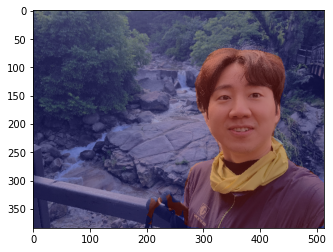

In [48]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

**1-8 세그멘테이션 결과(mask) 원래 크기로 복원**

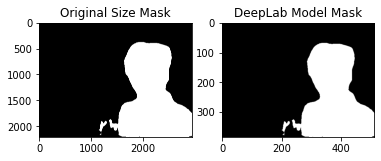

In [49]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

**1-9 배경 흐리게 만들기**

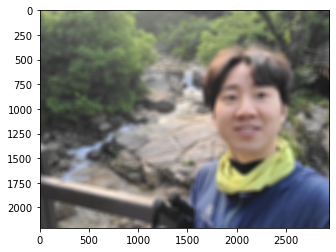

In [50]:
img_orig_blur = cv2.blur(img_orig, (50,50)) #(50,50)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

**1-10 흐려진 배경만 추출**

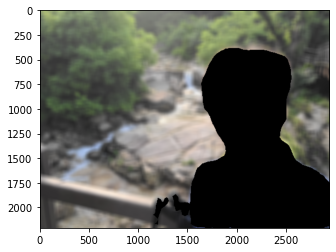

In [51]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

**1-11 배경과 사람 합치기**

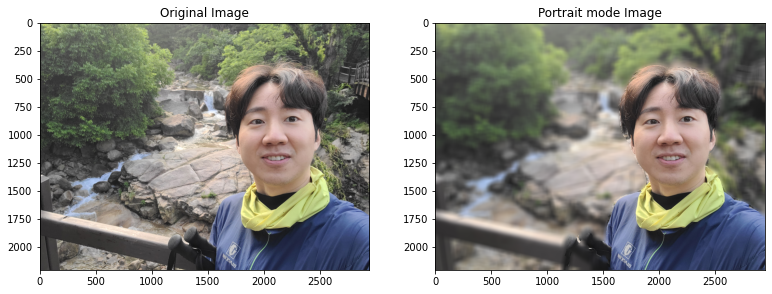

In [52]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(13,13))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()

**1-12 강아지 사진에 인물모드 적용하기**

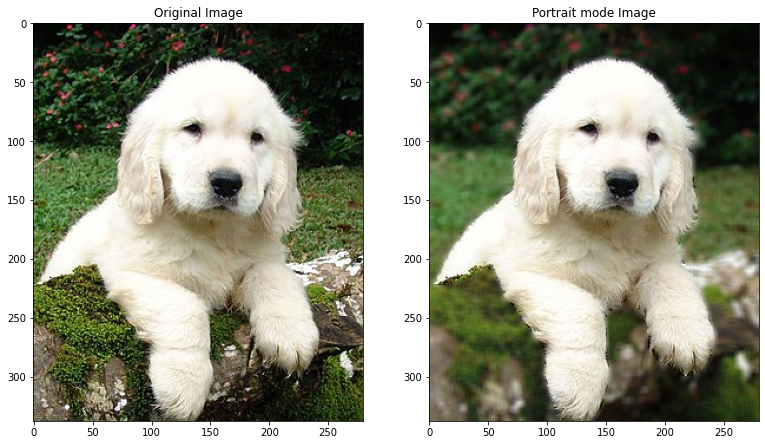

In [10]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog_image.jpg' 
img_orig = cv2.imread(img_path)

# 네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)

# 강아지 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 강아지만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask) 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (6, 6))

# 흐려진 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# 배경과 강아지 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(13,13))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()

**1-13 고양이 사진에 인물모드 적용하기**

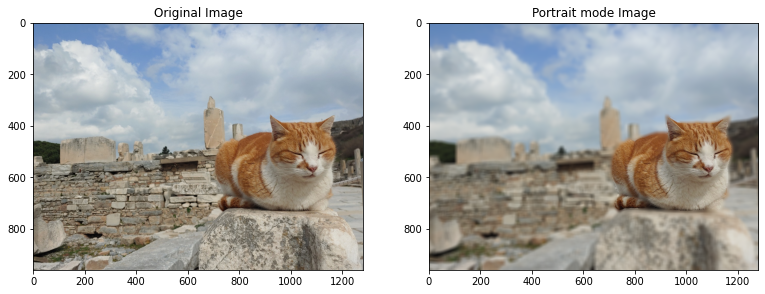

In [11]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.jpg' 
img_orig = cv2.imread(img_path)

# 네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)

# 고양이 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask) 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (16, 16))

# 흐려진 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# 배경과 고양이 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(13,13))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Portrait mode Image')

plt.show()

**1-14 배경전환 크로마키 사진 만들기**

In [18]:
# 배경 이미지 불러오기
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/reed.jpg'
bg_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.png'
bg_orig = cv2.imread(bg_path)
bg_orig1 = cv2.imread(bg_path1)
print(bg_orig.shape)
print(bg_orig1.shape)

(640, 960, 3)
(554, 692, 3)


In [19]:
# 배경 사이즈 변경
target_size = (img_orig.shape[1], img_orig.shape[0])
bg_resized = cv2.resize(bg_orig, target_size)
bg_resized1 = cv2.resize(bg_orig1, target_size)
print(bg_resized.shape)
print(bg_resized1.shape)

(960, 1280, 3)
(960, 1280, 3)


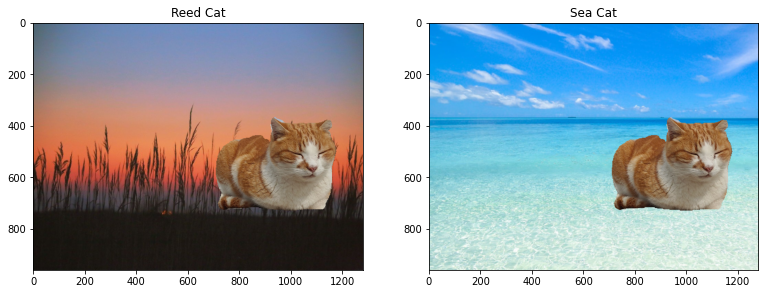

In [22]:
# 배경과 고양이 합치기
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
img_concat1 = np.where(img_mask_color==255, img_orig, bg_resized1)

plt.figure(figsize=(13,13))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Reed Cat')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.title('Sea Cat')

plt.show()

### ■ Step2 사진에서 문제점 찾기

---

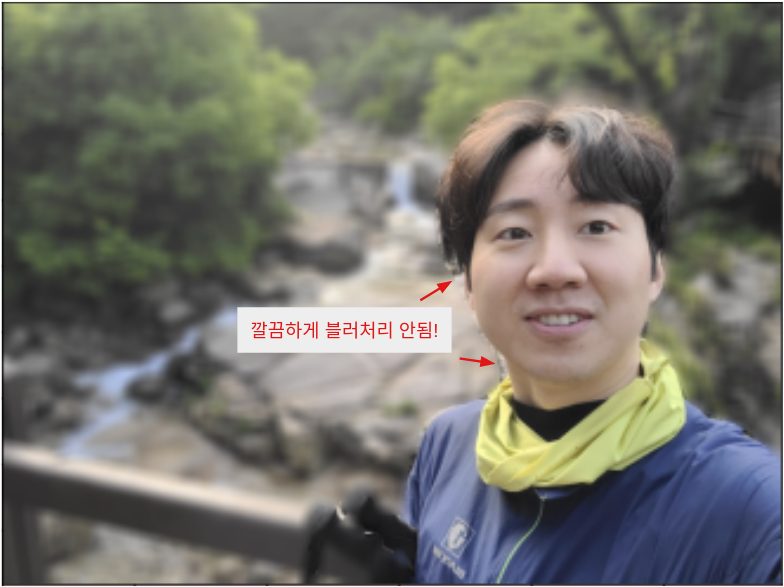

- 경계면이 깔끔하게 아웃포커싱 되지 않았다. 사람으로 검출된 영역이 정밀하지 않은 것 같다.

### ■ Step3 해결 방법을 제안해 보기

---

**3-1 피사계 심도 이해하기**

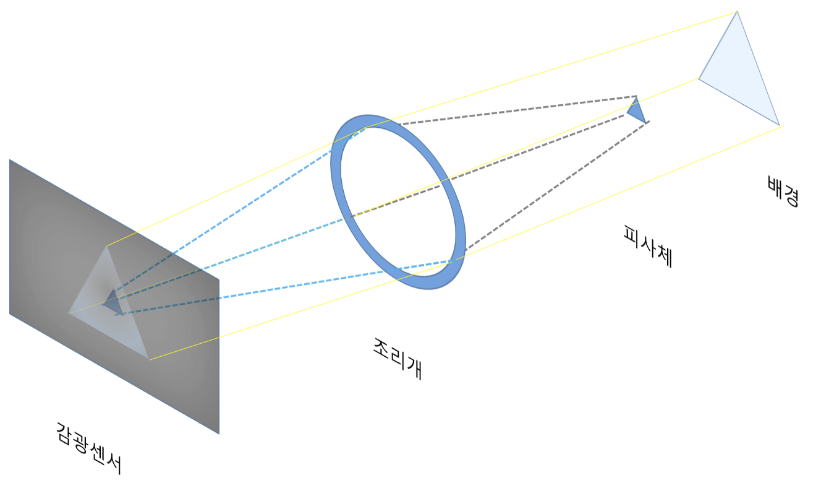

<center>[출처] https://ggyul.tistory.com/12</center>

- 아웃포커싱을 이해하려면 사진이 찍히는 원리를 이해해야 한다.
- 사진기에는 렌즈와 조리개가 있다.
- 렌즈는 피사체의 빛을 굴절시켜 필름에 영상 시키는 역할
- 조리개는 빛을 받아들이는 양을 조절하는 역할을 한다.
- 촛점을 피사체에 맞추면 피사체는 정확하게 필름에 영사되지만, 피사체 뒤의 배경은 정확하게 필름에 영사되지 않는다.
- 특히 조리개가 개방되어 빛의 양이 많아질 수록 배경의 촛점은 더 흐려지게 된다.
- 따라서 아웃포커싱을 잘 하려면 조리개 값이 낮은(조리개가 많이 개방되는) 렌즈를 써야 한다.

**3-2 그렇다면.. 조리개를 조절해서 빛의 양을 조절한다면, 블러값을 조절해볼까? (실패)**

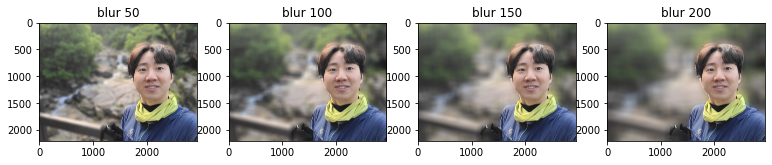

In [9]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my3.jpg' 
img_orig = cv2.imread(img_path)

# 네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)

# 사람 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask) 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (50, 50))
img_orig_blur1 = cv2.blur(img_orig, (100, 100))
img_orig_blur2 = cv2.blur(img_orig, (150, 150))
img_orig_blur3 = cv2.blur(img_orig, (200, 200))

# 흐려진 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_bg_blur1 = cv2.bitwise_and(img_orig_blur1, img_bg_mask)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask)

# 배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat1 = np.where(img_mask_color==255, img_orig, img_bg_blur1)
img_concat2 = np.where(img_mask_color==255, img_orig, img_bg_blur2)
img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur3)

plt.figure(figsize=(13,13))

plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('blur 50')

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.title('blur 100')

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.title('blur 150')

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.title('blur 200')

plt.show()

- 사람으로 검출된 영역자체가 넓기 때문에, 배경의 블러값을 조정한다고 경계면이 깔끔하게 되진 않았다..
- 그렇다면 검출 할 때부터 어떻게 하면 더 정교하게 사람을 검출할 수 있을까?

**3-3 사람으로 검출한 영역의 테두리를 미리 살짝 블러처리 할 수 있을까? (제안)**

- 코드로 구현해보려고 했지만, 어떻게 해야할지 모르겠다..

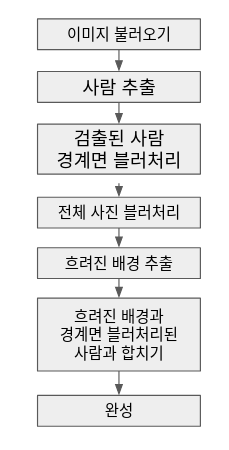

### ■ 정리 및 회고

- (step1) 사람 사진에 인물사진 모드 적용은 노드를 따라서 잘 진행하였다.

- (step1) 검출 라벨 값을 바꿔 강아지, 고양이 사진도 잘 성공하였다!

- (step1) 배경을 바꾸는 크로마키 부분에서 어려움이 있었는데, 배경사진의 사이즈와 고양이 검출 사진의 사이즈가 맞지 않는 문제였다. 고양이 원본 사진의 가로, 세로를 taget_size로 두고 배경사진 사이즈를 바꾸어 겨우 해결하였다. 이때 가로와 세로의 입력 순서를 바꿔줘야했다.

- (step2) 사람 사진에서 경계면이 깔끔하게 검출되지 않아 아웃포커싱이 완벽하게 되지 않은 문제를 확인했다.

- (step3) 블러값을 더 크게 주면 해결되지 않을까 했는데, 실패했다.

- (step3) 사람으로 검출한 영역의 테두리도 블러처리를 하고, 블러처리된 배경과 합치면 해결될 것 같은데 구현하지는 못했다.

- (step3) 다른 모델들에 대해서도 찾아보았지만, 아직 코드로 구현하지는 못할 것 같다. 다른 모델에 대해서 더 공부하고 이해하고, 코드로 구현하는 실력도 쌓아야겠다..

- 점점 더 exploration 내용이 깊어지는 것 같아 두렵지만 더 힘내봐야겠다..!